In [6]:
# import libraries
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.signal as signal
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import scipy
import peakutils

In [55]:
Ac225foilCountDirectory="count_room_data/experiment/225Ac"
Ac225files = glob.glob(Ac225foilCountDirectory+'*.Spe')
foilCountDirectory="count_room_data/experiment/monitor_foils/"
foilfiles = glob.glob(foilCountDirectory+'*.Spe')

In [58]:
foilfiles


['count_room_data/experiment/monitor_foils/AN111218_Y02_60cm_003.Spe',
 'count_room_data/experiment/monitor_foils/AQ111218_Ni01_60cm_027.Spe',
 'count_room_data/experiment/monitor_foils/AN111218_Y02_60cm_017.Spe',
 'count_room_data/experiment/monitor_foils/AQ111218_Ni01_60cm_033.Spe',
 'count_room_data/experiment/monitor_foils/AL111218_Y01_60cm_041.Spe',
 'count_room_data/experiment/monitor_foils/AO111218_In01_30cm_027.Spe',
 'count_room_data/experiment/monitor_foils/AK111218_Zr01_70cm_018.Spe',
 'count_room_data/experiment/monitor_foils/AK111218_Zr01_70cm_024.Spe',
 'count_room_data/experiment/monitor_foils/AK111218_Zr01_70cm_030.Spe',
 'count_room_data/experiment/monitor_foils/AM111218_Zr02_50cm_041.Spe',
 'count_room_data/experiment/monitor_foils/AP111218_In02_30cm_043.Spe',
 'count_room_data/experiment/monitor_foils/AM111218_Zr02_50cm_040.Spe',
 'count_room_data/experiment/monitor_foils/AP111218_In02_30cm_042.Spe',
 'count_room_data/experiment/monitor_foils/AK111218_Zr01_70cm_031.S

In [39]:
# Init a dict
dictFoilCount = {}

# Loop through files, create pandas panda frame
for file in files:
    name = file.split('_')[5]
    df = pd.read_table(file)
    data  = np.array(df['$SPEC_ID:'][11:16395], dtype='float')
    dictFoilCount[name] = data
keysFoilCount = list(dictFoilCount.keys())

In [40]:
#cell energy calibration
def chan2E(channel):
        b0=-.07173963760775197
        b1=.18743348208034852
        E=b0+b1*channel
        return E

In [41]:
#cell energy decalibration
def E2chan(E):
        b0=-.07173963760775197
        b1=.18743348208034852
        channel=(E-b0)/b1
        return channel

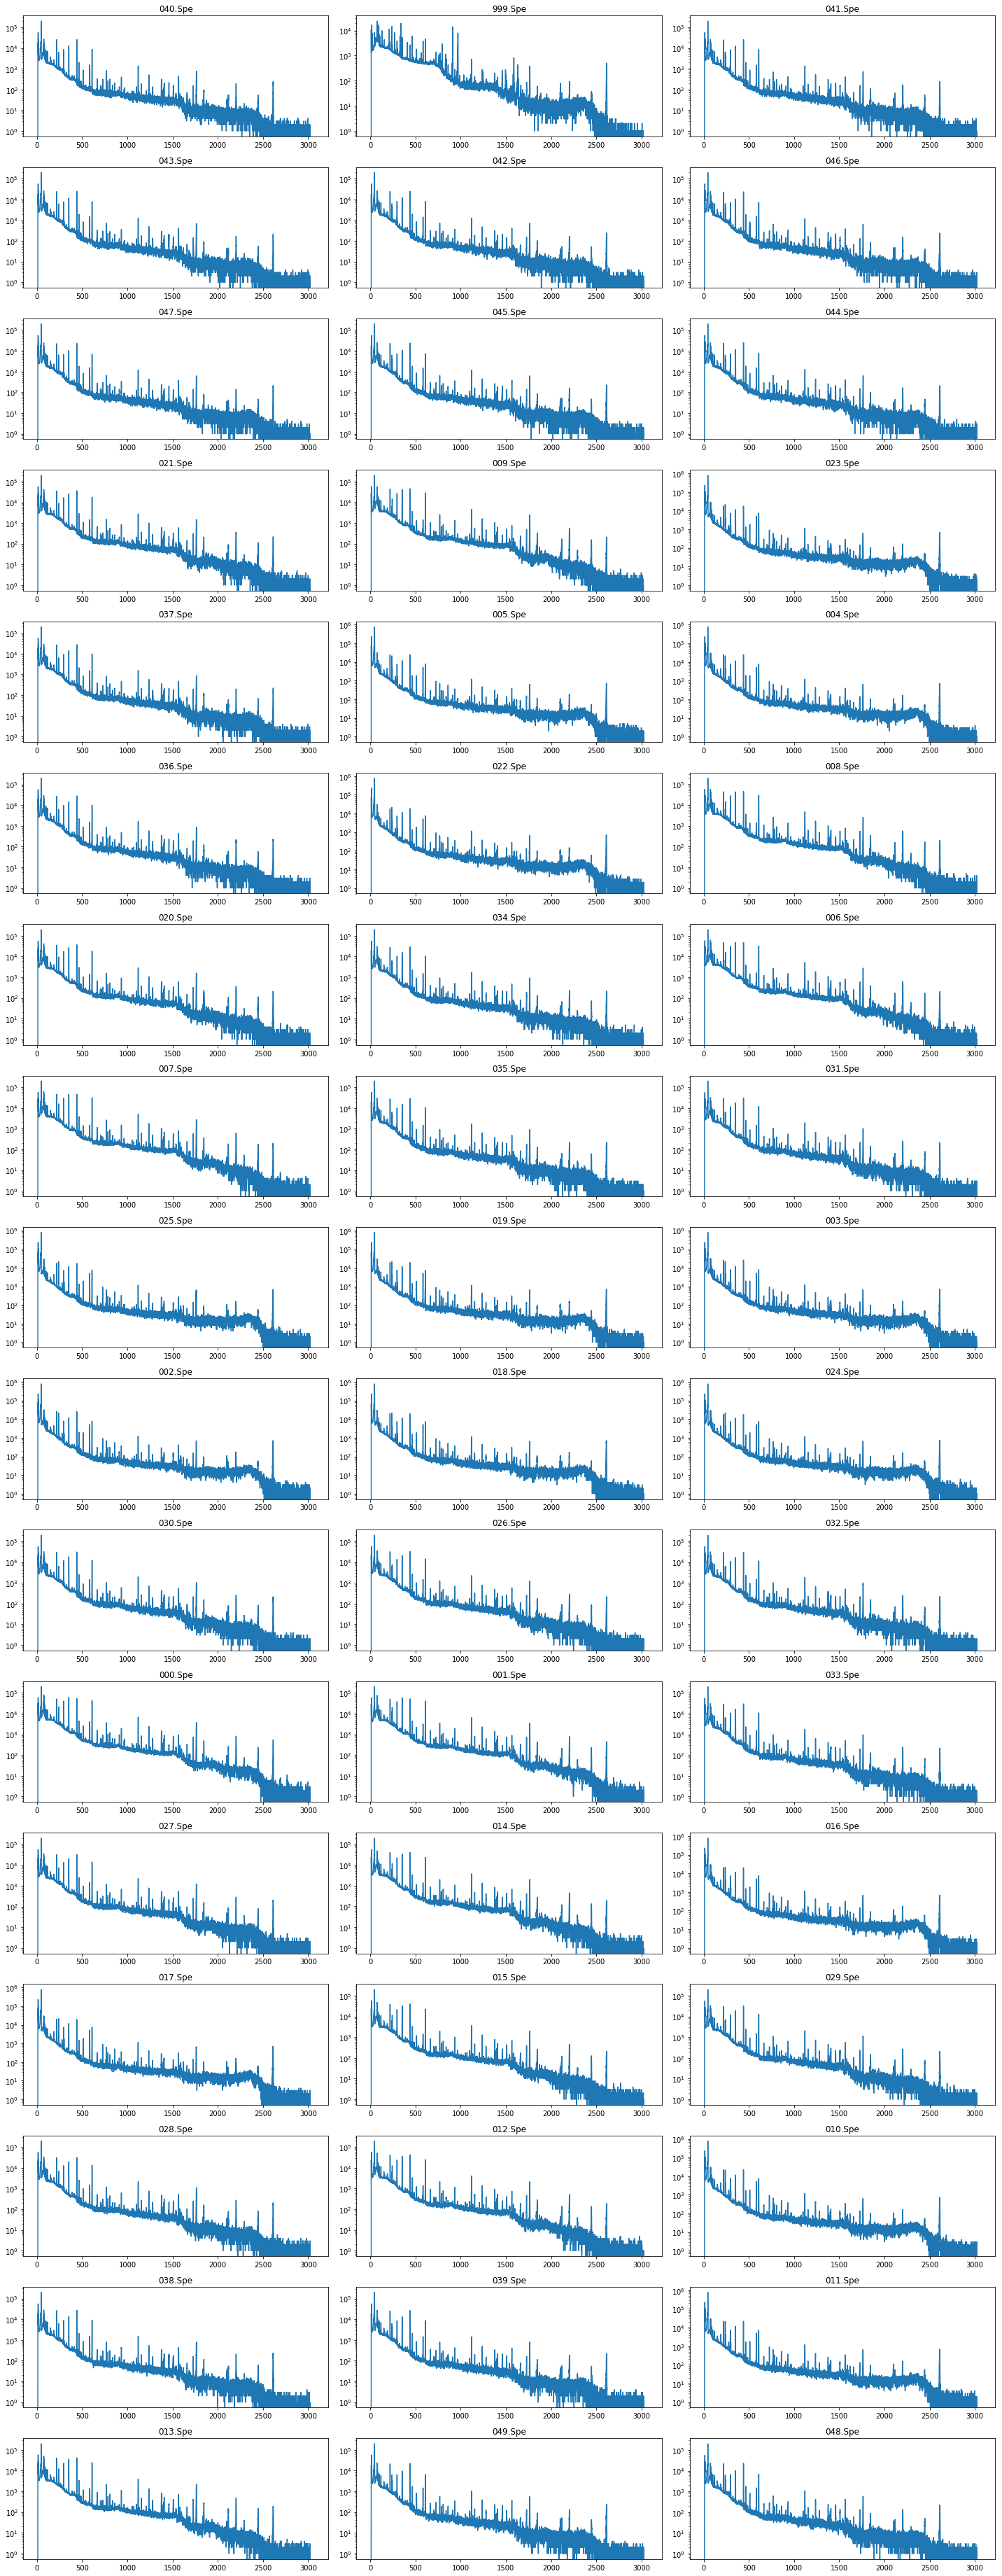

In [46]:
# plt.subplots(6,3)
plt.figure(figsize=(20,60))
i = 1
for name in keysFoilCount:
    plt.subplot(20,3,i)
    chan = np.linspace(1,len(dictFoilCount[name]), len(dictFoilCount[name]))
    plt.semilogy(chan2E(chan), dictFoilCount[name])
    plt.plot()
    plt.title(name)
    i = i+1
plt.tight_layout()

In [ ]:
left_endpt=14600
right_endpt=14800
plt.figure(figsize=(20,20))
i = 1
for name in keysFoilCount:
    plt.subplot(6,3,i)
    chan = np.linspace(left_endpt, right_endpt, right_endpt-left_endpt)
    plt.semilogy(chan2E(chan), dictFoilCount[name][left_endpt:right_endpt])
    plt.plot()
    plt.title(name)
    i = i+1
plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,20))
dictMaxGamma={}
dictMaxChannel={}
i = 1
for name in keysFoilCount:
    maxGamma=dictFoilCount[name][left_endpt]
    maxChannel=0
    j=[i for i in range(left_endpt,right_endpt)]
    for j in range(left_endpt,right_endpt):
        if dictFoilCount[name][j]>maxGamma:
            maxGamma=int(dictFoilCount[name][j])
            maxChannel=j
    dictMaxGamma[name]=maxGamma
    dictMaxChannel[name]=maxChannel
    i+=1
for name in keysFoilCount:
    print (name, dictMaxGamma[name], dictMaxChannel[name])

In [ ]:
x = data[:,2]
y = data[:,3]
mean = sum(x*y)
sigma = sum(y*(x - mean)**2)

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
popt, pcov = curve_fit(gauss_function, x, y, p0 = [1, mean, sigma])
plt.plot(x, gauss_function(x, *popt), label='fit')

# plot data

plt.plot(x, y,'b')

# Add some axis labels

plt.legend()
plt.title('Fig. 3 - Fit for Time Constant')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()

plt.figure(figsize=(20,20))
i = 1
for name in keysFoilCount:
    plt.subplot(6,3,i)
    chan = np.linspace(left_endpt, right_endpt, right_endpt-left_endpt)
    count=dictFoilCount[name][left_endpt:right_endpt]
    
    plt.semilogy(chan2E(chan), dictFoilCount[name][left_endpt:right_endpt])
    plt.plot()
    plt.title(name)
    i = i+1
plt.tight_layout()